In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model
from sklearn.metrics import classification_report

In [2]:
tf.random.set_seed(42)
np.random.seed(1337)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unzip folder and define data directory.
data_source = "/content/drive/MyDrive/Data_Visualization/Project/Data/Covid_Dataset.rar"
data_output = "/content"
!unrar x -Y $data_source $data_output

Streaming output truncated to the last 5000 lines.
Extracting  /content/Covid_Dataset/train/Normal/Normal_10764.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10765.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10769.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_1077.png           50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10770.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10771.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10772.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10773.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10774.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10775.png          50%  OK 
Extracting  /content/Covid_Da

In [5]:
#Define the hyper parameters
data_dir = "/content/Covid_Dataset"
classes = ['COVID','Normal']
initial_epochs = 50
initial_LR = 0.0001
dropout = 0.2
batch_size = 64
configuration = 'DenseNet_'+str(initial_LR)+'_WD_'+str(dropout)+'_'+str(batch_size)+'_V7'

In [6]:
! mkdir $configuration

In [7]:
train_path = data_dir + '//train'
valid_path = data_dir + '//valid'
test_path = data_dir + '//test'

In [8]:
train_batches = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory=train_path, classes=classes, target_size=(224, 224), batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory=valid_path, classes=classes, target_size=(224, 224), batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory=test_path, classes=classes, target_size=(224, 224), batch_size=batch_size, shuffle=False)

Found 8500 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


In [9]:
#Define input shape and use the weights from Imagenet and the network
INPUT_SHAPE = (224,224,3) 
base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

In [10]:
for layer in base_model.layers:
  if('conv1' in layer.name or 'conv2' in layer.name):
    layer.trainable = False
  else:
    continue

In [11]:
#Define the model
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
outputs = Dense(2, activation='sigmoid')(x)

In [12]:
model = keras.Model(inputs = base_model.input, outputs = outputs, name='DenseNet_121')

In [13]:
model.summary()

Model: "DenseNet_121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                       

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.689121 to fit



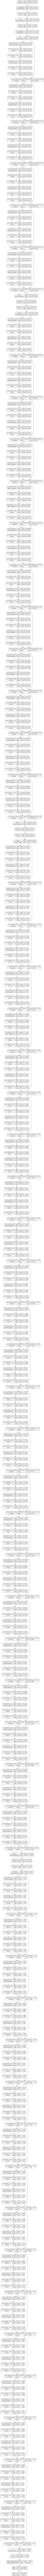

In [14]:
tf.keras.utils.plot_model(model, to_file= '/content/'+configuration+'/'+configuration+'_MODEL.png', show_shapes=True, show_layer_names=True)

In [15]:
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
checkpoint_callback = ModelCheckpoint('/content/'+configuration+'/'+configuration+'.h5', monitor='val_loss', save_best_only=True, mode='min')
model.compile(optimizer=Adam(learning_rate=initial_LR, decay=initial_LR / initial_epochs), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(
      train_batches,
      epochs = initial_epochs,
      validation_data=valid_batches,
      verbose=1,
      callbacks = [earlystopping_callback,checkpoint_callback]
    )

Epoch 1/50
133/133 [==============================] - 97s 597ms/step - loss: 0.1219 - accuracy: 0.9549 - val_loss: 0.0823 - val_accuracy: 0.9725
Epoch 2/50
133/133 [==============================] - 71s 536ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0326 - val_accuracy: 0.9875
Epoch 3/50
133/133 [==============================] - 71s 534ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 4/50
133/133 [==============================] - 70s 524ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0181 - val_accuracy: 0.9925
Epoch 5/50
133/133 [==============================] - 71s 533ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9950
Epoch 6/50
133/133 [==============================] - 70s 525ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9925
Epoch 7/50
133/133 [==============================] - 71s 534ms/step - loss: 4.8997e-04 - accuracy: 1.0000 - val_loss: 0.0087 - va

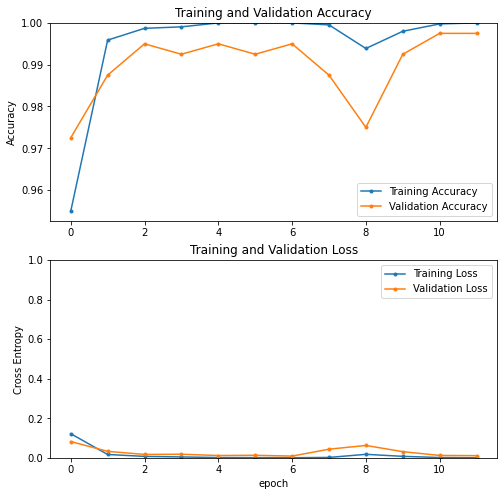

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker = '.')
plt.plot(val_acc, label='Validation Accuracy', marker = '.')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker = '.')
plt.plot(val_loss, label='Validation Loss', marker = '.')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/'+configuration+'/'+configuration+'_CURVE.png')
plt.show()

In [18]:
ran_epochs = len(history.history['accuracy'])
best_epoch = 0
if(ran_epochs != 50):
  if(ran_epochs > 5):
    best_epoch = ran_epochs - 6  
  else:
    best_epoch = 0
else:
  best_epoch = 49

In [19]:
train_accuracy = history.history['accuracy'][best_epoch]
train_loss = history.history['loss'][best_epoch]
train_accuracy = round(train_accuracy * 100,2)
train_loss = round(train_loss,2)
print(f'Training Accuracy: {train_accuracy}%')
print(f'Training Loss: {train_loss}')

Training Accuracy: 100.0%
Training Loss: 0.0


In [20]:
valid_accuracy = history.history['val_accuracy'][best_epoch]
valid_loss = history.history['val_loss'][best_epoch]
valid_accuracy = round(valid_accuracy * 100,2)
valid_loss = round(valid_loss,2)
print(f'Validation Accuracy: {valid_accuracy}%')
print(f'Validation Loss: {valid_loss}')

Validation Accuracy: 99.5%
Validation Loss: 0.01


In [21]:
#Returns the loss value & metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(test_batches)
test_accuracy = round(test_accuracy * 100,2)
test_loss = round(test_loss,2)
print(f'Testing Accuracy: {test_accuracy}%')
print(f'Testing Loss: {test_loss}')

20/20 [==============================] - 6s 280ms/step - loss: 0.0207 - accuracy: 0.9936
Testing Accuracy: 99.36%
Testing Loss: 0.02


In [22]:
results = {'Training Accuracy': train_accuracy, 'Training Loss':train_loss,
           'Validation Accuracy':valid_accuracy,'Validation Loss':valid_loss,
           'Testing Accuracy':test_accuracy,'Testing Loss':test_loss}
results_df = pd.DataFrame(results, index = [configuration])
results_df = results_df.round(2)
results_df.to_csv('/content/'+configuration+'/'+configuration+'_RESULTS.csv')
results_df

Training Accuracy  Training Loss  \
DenseNet_0.0001_WD_0.2_64_V7              100.0            0.0   

                              Validation Accuracy  Validation Loss  \
DenseNet_0.0001_WD_0.2_64_V7                 99.5             0.01   

                              Testing Accuracy  Testing Loss  
DenseNet_0.0001_WD_0.2_64_V7             99.36          0.02

In [23]:
predictions = model.predict(x=test_batches)

20/20 [==============================] - 5s 180ms/step


In [24]:
#let's print a classification report
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=classes, output_dict=True)
df = pd.DataFrame(cr).transpose()
df = df.round(2)
df.to_csv('/content/'+configuration+'/'+configuration+'_CR.csv')
print(df)

              precision  recall  f1-score  support
COVID              1.00    0.99      0.99   626.00
Normal             0.99    1.00      0.99   626.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.99    0.99      0.99  1252.00
weighted avg       0.99    0.99      0.99  1252.00


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/'+configuration+'/'+configuration+'_CM.png')

Confusion matrix, without normalization


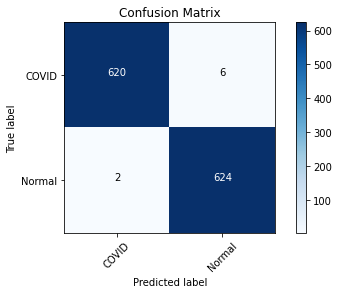

In [26]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

In [27]:
! cp -r "/content/"$configuration "/content/drive/MyDrive/Data_Visualization/Project/Networks"